In [ ]:
from google.colab import drive

# Kết nối với Google Drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install numpy

In [ ]:
import numpy as np

In [ ]:
np.load("/content/gdrive/MyDrive/RL/Dichuyen/DaLoc/DaLoc.npy")

array([[ 11.9545621, 108.4444886],
       [ 11.9545458, 108.4444923],
       [ 11.9545443, 108.4444848],
       ...,
       [ 11.9555555, 108.4440804],
       [ 11.9555564, 108.4441055],
       [ 11.9555515, 108.4441135]])

In [ ]:
np.load("/content/gdrive/MyDrive/RL/Dichuyen/Reward/Reward.npy")

array([[ 11.9541261 , 108.4445094 ],
       [ 11.9542455 , 108.4446187 ],
       [ 11.95469527, 108.44445275],
       [ 11.95479498, 108.44427036],
       [ 11.95470576, 108.44388278]])

In [ ]:
!pip install tensorflow


In [ ]:
!pip install tensorflow==2.10

  Using cached tensorflow-2.10.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.1 kB)
  Using cached keras-2.10.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached protobuf-3.19.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (787 bytes)
  Using cached tensorboard-2.10.1-py3-none-any.whl.metadata (1.9 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl.metadata (1.1 kB)
Using cached tensorflow-2.10.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (578.0 MB)
Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)
Using cached protobuf-3.19.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.6.0
    Uninstalling keras-3.6.0:
      Successfully uninstalled keras-3.6.0


In [ ]:
!pip install gym

!pip install keras

In [ ]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random

Episode: 1, Score: 10, Epsilon: 0.995
Episode: 2, Score: 10, Epsilon: 0.990
Episode: 3, Score: 10, Epsilon: 0.985
Episode: 4, Score: 10, Epsilon: 0.980
Episode: 5, Score: 10, Epsilon: 0.975
Episode: 6, Score: 10, Epsilon: 0.970
Episode: 7, Score: 10, Epsilon: 0.966
Episode: 8, Score: 10, Epsilon: 0.961
Episode: 9, Score: 10, Epsilon: 0.956
Episode: 10, Score: 10, Epsilon: 0.951
Episode: 11, Score: 10, Epsilon: 0.946
Episode: 12, Score: 10, Epsilon: 0.942
Episode: 13, Score: 10, Epsilon: 0.937
Episode: 14, Score: 10, Epsilon: 0.932
Episode: 15, Score: 10, Epsilon: 0.928
Episode: 16, Score: 10, Epsilon: 0.923
Episode: 17, Score: 10, Epsilon: 0.918
Episode: 18, Score: 10, Epsilon: 0.914
Episode: 19, Score: 10, Epsilon: 0.909
Episode: 20, Score: 10, Epsilon: 0.905
Episode: 21, Score: 10, Epsilon: 0.900
Episode: 22, Score: 10, Epsilon: 0.896
Episode: 23, Score: 10, Epsilon: 0.891
Episode: 24, Score: 10, Epsilon: 0.887
Episode: 25, Score: 10, Epsilon: 0.882
Episode: 26, Score: 10, Epsilon: 0

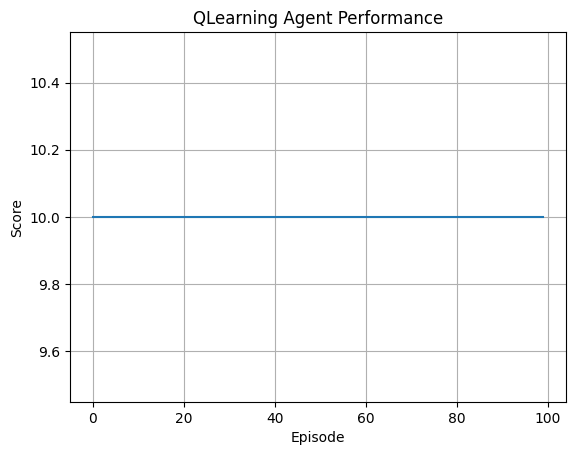

In [ ]:
import matplotlib.pyplot as plt

class LocationEnv(Env):
    def __init__(self, npy_file_path, reward_file_path):
        # Đọc dữ liệu từ file .npy (dữ liệu lộ trình)
        self.route_data = np.load(npy_file_path)
        self.current_index = 0  # Bắt đầu từ điểm đầu tiên trong lộ trình

        # Đọc tọa độ mục tiêu từ file reward.npy
        self.target_location = np.load(reward_file_path)

        # Action space: 3 hành động - Lùi lại, Tiến lên hoặc Giữ nguyên
        self.action_space = Discrete(3)  # 0: Lùi lại, 1: Tiến lên, 2: Giữ nguyên

        # Observation space: dựa trên giá trị kinh độ và vĩ độ từ dữ liệu
        low = np.min(self.route_data, axis=0)
        high = np.max(self.route_data, axis=0)
        self.observation_space = Box(low=low, high=high, dtype=np.float32)

        # Trạng thái ban đầu
        self.state = np.copy(self.route_data[self.current_index])

    def reset(self):
        # Đặt lại trạng thái về vị trí bắt đầu
        self.current_index = 0
        self.state = np.copy(self.route_data[self.current_index])
        return self.state.flatten()  # Trả về trạng thái phẳng

    def step(self, action):
        # Xử lý hành động
        if action == 1:  # Tiến lên
            if self.current_index < len(self.route_data) - 1:
                self.current_index += 1
        elif action == 0:  # Lùi lại
            if self.current_index > 0:
                self.current_index -= 1
        elif action == 2:  # Giữ nguyên
            pass  # Không thay đổi vị trí

        # Cập nhật trạng thái
        self.state = np.copy(self.route_data[self.current_index])

        # Tính phần thưởng dựa trên khoảng cách đến mục tiêu
        distance = np.linalg.norm(self.state - self.target_location)
        reward = -distance  # Phần thưởng âm theo khoảng cách, càng gần mục tiêu càng tốt

        # Kiểm tra nếu agent rất gần mục tiêu
        if distance < 0.001:
            done = True
            reward = 10  # Phần thưởng cao khi đạt gần mục tiêu
        else:
            done = self.current_index == len(self.route_data) - 1

        # Thông tin bổ sung
        info = {"distance": distance}

        return self.state.flatten(), reward, done, info  # Trả về trạng thái phẳng

    def render(self):
        # Hiển thị trạng thái hiện tại của môi trường
        print(f"Current State: {self.state}, Current Index: {self.current_index}")

        # Vẽ các điểm GPS trên bản đồ 2D sử dụng matplotlib
        plt.plot(self.route_data[:, 0], self.route_data[:, 1], label='Route', color='blue')
        plt.scatter(self.state[0], self.state[1], color='red', label='Current Location')
        plt.scatter(self.target_location[0], self.target_location[1], color='green', label='Target Location')
        plt.legend()
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title('GPS Path Visualization')
        plt.show()

# Khởi tạo môi trường và huấn luyện như trước
npy_file_path = r"/content/gdrive/MyDrive/RL/Dichuyen/DaLoc/DaLoc.npy"
reward_file_path = r"/content/gdrive/MyDrive/RL/Dichuyen/Reward/Reward.npy"
env = LocationEnv(npy_file_path, reward_file_path)

# Khởi tạo Q-learning agent và bắt đầu huấn luyện
agent = QLearningAgent(env)
agent.train(episodes=100)


In [ ]:
npy_file_path = r"/content/gdrive/MyDrive/RL/Dichuyen/DaLoc/DaLoc.npy"
reward_file_path = r"/content/gdrive/MyDrive/RL/Dichuyen/Reward/Reward.npy"
env = LocationEnv(npy_file_path, reward_file_path)

In [ ]:
!pip instal matplotlib

In [ ]:
import matplotlib.pyplot as plt

class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.env = env
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.epsilon_min = epsilon_min  # Minimum exploration rate
        self.epsilon_decay = epsilon_decay  # Epsilon decay factor

        # Khởi tạo Q-table với giá trị 0 cho tất cả các trạng thái và hành động
        self.q_table = np.zeros((len(env.route_data), env.action_space.n))

        # Biến để lưu điểm số mỗi episode
        self.scores = []

    def choose_action(self, state_index):
        # Epsilon-greedy strategy: chọn ngẫu nhiên hoặc chọn hành động tối ưu từ Q-table
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()  # Chọn hành động ngẫu nhiên (explore)
        else:
            return np.argmax(self.q_table[state_index])  # Chọn hành động tối ưu (exploit)

    def learn(self, state_index, action, reward, next_state_index):
        # Cập nhật Q-value theo công thức Q-learning
        predict = self.q_table[state_index, action]
        target = reward + self.gamma * np.max(self.q_table[next_state_index])
        self.q_table[state_index, action] += self.alpha * (target - predict)

    def decay_epsilon(self):
        # Giảm dần epsilon để giảm hành động ngẫu nhiên theo thời gian
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def train(self, episodes=1000):
        for episode in range(episodes):
            state = self.env.reset()
            state_index = self.env.current_index
            done = False
            score = 0

            while not done:
                action = self.choose_action(state_index)
                next_state, reward, done, info = self.env.step(action)
                next_state_index = self.env.current_index

                # Học từ kinh nghiệm
                self.learn(state_index, action, reward, next_state_index)

                # Cập nhật trạng thái
                state_index = next_state_index
                score += reward

            # Lưu lại điểm số sau mỗi episode
            self.scores.append(score)

            # Giảm epsilon sau mỗi episode
            self.decay_epsilon()

            print(f"Episode: {episode + 1}, Score: {score}, Epsilon: {self.epsilon:.3f}")

        print("Training finished.")

        # Plotting the score progress
        self.plot_scores()

    def plot_scores(self):
        # Vẽ biểu đồ điểm số qua từng episode
        plt.plot(self.scores)
        plt.title("QLearning Agent Performance")
        plt.xlabel("Episode")
        plt.ylabel("Score")
        plt.grid()
        plt.show()

# Khởi tạo môi trường và agent sau khi đã sửa đổi
env = LocationEnv(npy_file_path, reward_file_path)
agent = QLearningAgent(env)
agent.train(episodes=100)


NameError: name 'npy_file_path' is not defined

In [ ]:
env.observation_space.sample()

array([ 11.955463, 108.44439 ], dtype=float32)

In [ ]:
print(env.observation_space.shape)


(2,)


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:

states = env.observation_space.shape[0]
actions = env.action_space.n

In [ ]:
input_shape = env.observation_space.shape

model = Sequential()
model.add(Flatten(input_shape=input_shape))  # Ensure the input is flattened
model.add(Dense(24, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(env.action_space.n, activation='linear'))  # Output layer for actions

In [ ]:
actions

3

In [ ]:
def build_model(states, actions):
    model = Sequential()
    model.add(Dense(24, activation='relu', input_shape=(states,)))  # Vẫn giữ nguyên
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model


In [ ]:
!pip install keras-rl


In [ ]:
!pip install keras-rl2


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
import numpy as np

# Giả sử bạn đã có môi trường 'env' sẵn sàng

# Hàm xây dựng mô hình
def build_model(states, actions):
    model = Sequential()
    model.add(Flatten(input_shape=(1, states)))  # Flatten input (1, states)
    model.add(Dense(24, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))  # Output layer for actions
    return model

# Kích thước không gian quan sát và không gian hành động
states = np.prod(env.observation_space.shape)  # Number of state values (flattened size)
actions = env.action_space.n  # Number of actions

# Xây dựng mô hình
model = build_model(states, actions)

# Khởi tạo bộ nhớ
memory = SequentialMemory(limit=50000, window_length=1)

# Chính sách BoltzmannQPolicy
policy = BoltzmannQPolicy()

# Khởi tạo agent DQN
dqn = DQNAgent(model=model, memory=memory, policy=policy,
               nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)

# Compile the DQN agent
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

# Huấn luyện agent và hiển thị quá trình học
import gym

# Tạo môi trường với render_mode phù hợp
env = gym.make('LocationEnv', render_mode='human')  # 'human' để hiển thị đồ họa

# Tiếp tục với quá trình huấn luyện
dqn.fit(env, nb_steps=50000, visualize=True, verbose=1)



/usr/local/lib/python3.10/dist-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


NameNotFound: Environment LocationEnv doesn't exist. 

In [ ]:

model = build_model(states, actions)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 2)                 0         
                                                                 
 dense_3 (Dense)             (None, 24)                72        
                                                                 
 dense_4 (Dense)             (None, 24)                600       
                                                                 
 dense_5 (Dense)             (None, 3)                 75        
                                                                 
Total params: 747
Trainable params: 747
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Sau khi huấn luyện hoàn tất
# Giả sử bạn đã huấn luyện mô hình Q-learning trong phần trước
agent.train(episodes=100)

# Sau khi huấn luyện, bạn có thể lưu trữ Q-table
np.save('q_table.npy', agent.q_table)


In [ ]:
# Lưu mô hình DQN
dqn.model.save('dqn_model.h5')  # Lưu toàn bộ mô hình (weights + architecture)


In [ ]:
# Tải lại Q-table
q_table = np.load('q_table.npy')

# Sử dụng mô hình đã huấn luyện trong ứng dụng
# Chọn hành động từ Q-table cho một trạng thái cụ thể
state_index = 10  # Ví dụ về một trạng thái
action = np.argmax(q_table[state_index])  # Chọn hành động tối ưu


In [ ]:
import numpy as np
from keras.models import load_model

# Giả sử bạn đã tải mô hình đã huấn luyện
model = load_model('dqn_model.h5')

# Hàm quyết định hành động trong ứng dụng chỉ đường
def choose_action(state):
    # Dự đoán hành động từ mô hình DQN
    action = np.argmax(model.predict(state.reshape(1, 1, 2)))  # Dự đoán hành động tối ưu
    return action

npy_file_path = r"/content/gdrive/MyDrive/RL/Dichuyen/DaLoc/DaLoc.npy"
reward_file_path = r"/content/gdrive/MyDrive/RL/Dichuyen/Reward/Reward.npy"
# Đọc tọa độ từ file .npy
user_positions = np.load(npy_file_path)  # Mảng (n, 2), mỗi dòng là [longitude, latitude]
destination_positions = np.load(reward_file_path)  # Mảng (m, 2), mỗi dòng là [longitude, latitude]

# Giả sử bạn muốn tính khoảng cách đến từng điểm đích
for current_position in user_positions:
    print(f"Current Position: {current_position}")

    # Chọn hành động dựa trên mô hình đã huấn luyện
    action = choose_action(current_position)

    # Thực hiện hành động trong ứng dụng (ví dụ: di chuyển đến điểm tiếp theo)
    # Cập nhật vị trí người dùng sau khi hành động
    if action == 0:  # Ví dụ: di chuyển về phía trước (tiến lên)
        current_position += [0.0001, 0.0001]  # Cập nhật vị trí mới (di chuyển lên trên)
    elif action == 1:  # Quay trái (có thể thay bằng hành động quay trái thực tế)
        current_position += [-0.0001, 0.0001]  # Quay trái (giảm longitude, tăng latitude)
    elif action == 2:  # Quay phải (có thể thay bằng hành động quay phải thực tế)
        current_position += [0.0001, -0.0001]  # Quay phải (tăng longitude, giảm latitude)

    # Hiển thị vị trí mới trên bản đồ hoặc UI của ứng dụng
    print(f"New Position: {current_position}")

    # (Tùy chọn) Kiểm tra khoảng cách đến từng điểm đích
    for destination_position in destination_positions:
        distance_to_target = np.linalg.norm(current_position - destination_position)
        print(f"Distance to target: {distance_to_target:.4f}")


In [ ]:
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt

# Giả sử bạn đã tải mô hình đã huấn luyện
model = load_model('dqn_model.h5')

# Hàm quyết định hành động trong ứng dụng chỉ đường
def choose_action(state):
    # Dự đoán hành động từ mô hình DQN
    action = np.argmax(model.predict(state.reshape(1, 1, 2)))  # Dự đoán hành động tối ưu
    return action

# Đọc tọa độ từ file .npy
npy_file_path = r"/content/gdrive/MyDrive/RL/Dichuyen/DaLoc/DaLoc.npy"
reward_file_path = r"/content/gdrive/MyDrive/RL/Dichuyen/Reward/Reward.npy"

# Đọc tọa độ từ file .npy
user_positions = np.load(npy_file_path)  # Mảng (n, 2), mỗi dòng là [longitude, latitude]
destination_positions = np.load(reward_file_path)  # Mảng (m, 2), mỗi dòng là [longitude, latitude]

# Tạo danh sách để lưu các tọa độ dự đoán
predicted_positions = []

# Giả sử bạn muốn tính khoảng cách đến từng điểm đích
for current_position in user_positions:
    print(f"Current Position: {current_position}")

    # Chọn hành động dựa trên mô hình đã huấn luyện
    action = choose_action(current_position)

    # Thực hiện hành động trong ứng dụng (ví dụ: di chuyển đến điểm tiếp theo)
    # Cập nhật vị trí người dùng sau khi hành động
    if action == 0:  # Di chuyển về phía trước (tiến lên)
        current_position += [0.0001, 0.0001]  # Cập nhật vị trí mới (di chuyển lên trên)
    elif action == 1:  # Quay trái
        current_position += [-0.0001, 0.0001]  # Quay trái (giảm longitude, tăng latitude)
    elif action == 2:  # Quay phải
        current_position += [0.0001, -0.0001]  # Quay phải (tăng longitude, giảm latitude)

    # Lưu vị trí dự đoán vào danh sách
    predicted_positions.append(current_position.copy())

    # Hiển thị vị trí mới trên bản đồ hoặc UI của ứng dụng
    print(f"New Position: {current_position}")

# Chuyển predicted_positions thành mảng numpy để dễ dàng vẽ
predicted_positions = np.array(predicted_positions)

# Vẽ bản đồ và các điểm
plt.figure(figsize=(10, 8))

# Vẽ các điểm GPS thực tế (màu xanh)
plt.scatter(user_positions[:, 0], user_positions[:, 1], c='blue', label='Real GPS', marker='o')

# Vẽ các điểm GPS dự đoán (màu đỏ)
plt.scatter(predicted_positions[:, 0], predicted_positions[:, 1], c='red', label='Predicted GPS', marker='x')

# Vẽ các điểm Reward (màu xanh lá cây)
plt.scatter(destination_positions[:, 0], destination_positions[:, 1], c='green', label='Reward (Destination)', marker='^')

# Thêm các đường nối giữa các điểm thực tế và dự đoán
for i in range(len(user_positions)):
    plt.plot([user_positions[i, 0], predicted_positions[i, 0]],
             [user_positions[i, 1], predicted_positions[i, 1]],
             'gray', linestyle='--')

# Kiểm tra khoảng cách giữa các điểm dự đoán và các điểm Reward (tọa độ đích)
for i, predicted_position in enumerate(predicted_positions):
    # Tính khoảng cách giữa điểm dự đoán và tất cả các điểm đích
    distances = np.linalg.norm(destination_positions - predicted_position, axis=1)

    # Tìm chỉ số của điểm đích gần nhất
    closest_index = np.argmin(distances)
    closest_distance = distances[closest_index]

    # Đánh dấu điểm dự đoán gần nhất với điểm đích
    if closest_distance < 0.001:  # Nếu khoảng cách nhỏ hơn 0.001, đánh dấu điểm
        plt.scatter(predicted_position[0], predicted_position[1], c='yellow', marker='*', s=200, label='Closest to Reward' if i == 0 else "")

# Thêm tiêu đề và nhãn cho trục
plt.title("Real GPS vs Predicted GPS Positions with Reward")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Thêm chú thích
plt.legend()

# Hiển thị bản đồ
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
input_shape = env.observation_space.shape
def build_model(states, actions):


    model = Sequential()
    model.add(Flatten(input_shape=input_shape))  # Ensure the input is flattened
    model.add(Dense(24, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(env.action_space.n, activation='linear'))  # Output layer for actions
    return model
# Kích thước không gian quan sát và không gian hành động
states = np.prod(env.observation_space.shape)  # Số lượng giá trị trong trạng thái (2)
actions = env.action_space.n  # Số lượng hành động (2 hành động: tiến và lùi)

# Xây dựng mô hình
model = build_model(states, actions)

# Khởi tạo bộ nhớ
memory = SequentialMemory(limit=50000, window_length=1)

# Chính sách sử dụng BoltzmannQPolicy
policy = BoltzmannQPolicy()

# Khởi tạo agent DQN
dqn = DQNAgent(model=model, memory=memory, policy=policy,
               nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/lib/python3.10/random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten  # Import Flatten
from keras.optimizers import Adam
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

# Function to build the model
def build_model(states, actions):
    model = Sequential()
    model.add(Flatten(input_shape=(1, states)))  # Flatten input (1, states) because DQN expects batch size in first dimension
    model.add(Dense(24, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))  # Output layer for actions
    return model  # Return the model

# Kích thước không gian quan sát và không gian hành động
states = np.prod(env.observation_space.shape)  # Number of state values (flattened size)
actions = env.action_space.n  # Number of actions (2 actions: forward and backward)

# Xây dựng mô hình
model = build_model(states, actions)

# Khởi tạo bộ nhớ
memory = SequentialMemory(limit=50000, window_length=1)

# Chính sách sử dụng BoltzmannQPolicy
policy = BoltzmannQPolicy()

# Khởi tạo agent DQN
dqn = DQNAgent(model=model, memory=memory, policy=policy,
               nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)

# Compile the DQN agent
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

# Start training
dqn.fit(env, nb_steps=50000, visualize=False, verbose=1)


Double DQN

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from rl.agents.dqn import DQNAgent  # DQN agent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

# Function to build the model
def build_model(states, actions):
    model = Sequential()
    model.add(Flatten(input_shape=(1, states)))  # Flatten input (1, states) because DQN expects batch size in the first dimension
    model.add(Dense(24, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))  # Output layer for actions
    return model  # Return the model

# Kích thước không gian quan sát và không gian hành động
states = np.prod(env.observation_space.shape)  # Number of state values (flattened size)
actions = env.action_space.n  # Number of actions (2 actions: forward and backward)

# Xây dựng mô hình online network (chính)
model = build_model(states, actions)

# Khởi tạo bộ nhớ
memory = SequentialMemory(limit=50000, window_length=1)

# Chính sách sử dụng BoltzmannQPolicy
policy = BoltzmannQPolicy()

# Khởi tạo agent Double DQN
dqn = DQNAgent(model=model, memory=memory, policy=policy,
               nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2,
               enable_double_dqn=True)  # Sử dụng Double DQN bằng cách bật cờ enable_double_dqn

# Compile the DQN agent
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

# Start training with Double DQN
dqn.fit(env, nb_steps=50000, visualize=False, verbose=1)


In [ ]:
# Huấn luyện agent
# Huấn luyện agent
dqn.fit(env, nb_steps=50000, visualize=False, verbose=1)


# Đánh giá agent sau khi huấn luyện
dqn.test(env, nb_episodes=5, visualize=False)

DDPQ

In [ ]:
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Input
from keras.optimizers import Adam
from rl.agents import DDPGAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess
from keras.layers import Concatenate
from gym.spaces import Box

class LocationEnv(Env):
    def __init__(self, npy_file_path, reward_file_path):
        # Đọc dữ liệu từ file .npy (dữ liệu lộ trình)
        self.route_data = np.load(npy_file_path)
        self.current_index = 0  # Bắt đầu từ điểm đầu tiên trong lộ trình

        # Đọc tọa độ mục tiêu từ file reward.npy
        self.target_location = np.load(reward_file_path)

        # Action space: Continuous action space
        self.action_space = Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)

        # Observation space: dựa trên giá trị kinh độ và vĩ độ từ dữ liệu
        low = np.min(self.route_data, axis=0)
        high = np.max(self.route_data, axis=0)
        self.observation_space = Box(low=low, high=high, dtype=np.float32)

        # Trạng thái ban đầu
        self.state = np.copy(self.route_data[self.current_index])

    def reset(self):
        # Đặt lại trạng thái về vị trí bắt đầu
        self.current_index = 0
        self.state = np.copy(self.route_data[self.current_index])
        return self.state.flatten()  # Trả về trạng thái phẳng

    def step(self, action):
        # Xử lý hành động
        action = action[0]
        max_step_size = 1  # Thiết lập kích thước bước tối đa
        if action > 0:  # Tiến lên
            step_size = int(np.clip(action * max_step_size, 1, max_step_size))
            self.current_index = min(self.current_index + step_size, len(self.route_data) - 1)
        elif action < 0:  # Lùi lại
            step_size = int(np.clip(-action * max_step_size, 1, max_step_size))
            self.current_index = max(self.current_index - step_size, 0)
        else:
            pass

        # Cập nhật trạng thái
        self.state = np.copy(self.route_data[self.current_index])

        # Tính phần thưởng dựa trên khoảng cách đến mục tiêu
        distance = np.linalg.norm(self.state - self.target_location)
        reward = -distance  # Phần thưởng âm theo khoảng cách, càng gần mục tiêu càng tốt

        # Kiểm tra nếu agent rất gần mục tiêu
        if distance < 0.001:
            done = True
            reward = 10  # Phần thưởng cao khi đạt gần mục tiêu
        else:
            done = self.current_index == len(self.route_data) - 1

        # Thông tin bổ sung
        info = {"distance": distance}

        return self.state.flatten(), reward, done, info  # Trả về trạng thái phẳng

    def render(self):
        # Hiển thị trạng thái hiện tại của môi trường
        print(f"Current State: {self.state}, Current Index: {self.current_index}")


# Xây dựng mạng Actor
def build_actor(states, actions):
    actor = Sequential()
    actor.add(Flatten(input_shape=(1, states)))  # Flatten input
    actor.add(Dense(24, activation='relu'))
    actor.add(Dense(24, activation='relu'))
    actor.add(Dense(actions, activation='tanh'))  # Continuous action space output
    return actor

# Xây dựng mạng Critic
def build_critic(states, actions):
    # Đầu vào quan sát (trạng thái)
    observation_input = Input(shape=(1, states), name='observation_input')
    flattened_observation = Flatten()(observation_input)

    # Đầu vào hành động
    action_input = Input(shape=(actions,), name='action_input')

    # Kết hợp (concatenate) giữa trạng thái và hành động
    concatenated = Concatenate()([flattened_observation, action_input])

    x = Dense(24, activation='relu')(concatenated)
    x = Dense(24, activation='relu')(x)
    q_output = Dense(1, activation='linear')(x)  # Output Q-value

    # Tạo mô hình Critic
    critic = Model(inputs=[observation_input, action_input], outputs=q_output)
    return critic


# Đường dẫn đến các file dữ liệu
npy_file_path = r"/content/gdrive/MyDrive/RL/Dichuyen/DaLoc/DaLoc.npy"
reward_file_path = r"/content/gdrive/MyDrive/RL/Dichuyen/Reward/Reward.npy"

# Khởi tạo môi trường
env = LocationEnv(npy_file_path, reward_file_path)

# Kích thước không gian quan sát và hành động
states = np.prod(env.observation_space.shape)
actions = env.action_space.shape[0]

# Xây dựng các mạng Actor và Critic
actor = build_actor(states, actions)
critic = build_critic(states, actions)

# Khởi tạo bộ nhớ
memory = SequentialMemory(limit=50000, window_length=1)

# Sử dụng Ornstein-Uhlenbeck process để thêm noise vào các hành động
random_process = OrnsteinUhlenbeckProcess(size=actions, theta=0.15, mu=0.0, sigma=0.2)

# Khởi tạo DDPG agent
ddpg = DDPGAgent(actor=actor, critic=critic, critic_action_input=critic.input[1],
                 memory=memory, nb_actions=actions, nb_steps_warmup_actor=100,
                 nb_steps_warmup_critic=100, random_process=random_process, gamma=0.99,
                 target_model_update=1e-3)

# Compile agent
ddpg.compile(Adam(lr=1e-3), metrics=['mae'])

# Huấn luyện agent
ddpg.fit(env, nb_steps=50000, visualize=False, verbose=1)

# Kiểm thử agent
ddpg.test(env, nb_episodes=5, visualize=False)


A3C - Asynchronous Advantage Actor-Critic

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from gym import Env
from gym.spaces import Box

In [ ]:
import tensorflow as tf
print("Eager execution enabled:", tf.executing_eagerly())


Eager execution enabled: True


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from gym.spaces import Box, Discrete
from gym import Env
import matplotlib.pyplot as plt
import threading


/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:246: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation
/usr/local/lib/python3.10/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:326: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),


In [ ]:
tf.enable_eager_execution()

AttributeError: module 'tensorflow' has no attribute 'enable_eager_execution'

ValueError: tf.enable_eager_execution must be called at program startup.

In [ ]:
tf.compat.v1.enable_eager_execution()

In [ ]:

# Kiểm tra xem eager execution đã được bật chưa
print("Eager execution enabled:", tf.executing_eagerly())

NameError: name 'tf' is not defined

In [ ]:
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.10.0


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from gym import Env
from gym.spaces import Discrete, Box
import matplotlib.pyplot as plt
import threading

# Custom Environment
class LocationEnv(Env):
    def __init__(self, npy_file_path, reward_file_path):
        self.route_data = np.load(npy_file_path)
        self.target_location = np.load(reward_file_path)
        self.current_index = 0

        self.action_space = Discrete(3)  # 0: Move Backward, 1: Move Forward, 2: Stay in Place
        low = np.min(self.route_data, axis=0)
        high = np.max(self.route_data, axis=0)
        self.observation_space = Box(low=low, high=high, dtype=np.float32)

        self.state = np.copy(self.route_data[self.current_index])

    def reset(self):
        self.current_index = 0
        self.state = np.copy(self.route_data[self.current_index])
        return np.expand_dims(np.copy(self.state), axis=0)  # Adding batch size

    def step(self, action):
        if action == 1:  # Move Forward
            if self.current_index < len(self.route_data) - 1:
                self.current_index += 1
        elif action == 0:  # Move Backward
            if self.current_index > 0:
                self.current_index -= 1
        elif action == 2:  # Stay in Place
            pass

        self.state = np.copy(self.route_data[self.current_index])

        # Compute reward based on distance to the target location
        distance = np.linalg.norm(self.state - self.target_location)
        reward = -distance  # Negative reward for distance

        # Check if agent is very close to the target
        done = distance < 0.001 or self.current_index == len(self.route_data) - 1

        if done:
            reward = 10  # Reward for reaching the target

        return np.expand_dims(np.copy(self.state), axis=0), reward, done, {"distance": distance}

    def render(self):
        # Display current state on a 2D map using matplotlib
        plt.plot(self.route_data[:, 0], self.route_data[:, 1], label='Route', color='blue')
        plt.scatter(self.state[0], self.state[1], color='red', label='Current Location')
        plt.scatter(self.target_location[0], self.target_location[1], color='green', label='Target Location')
        plt.legend()
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title('GPS Path Visualization')
        plt.show()


# Actor-Critic Network (Shared Network)
class ActorCritic(tf.keras.Model):
    def __init__(self, state_size, action_size):
        super(ActorCritic, self).__init__()
        self.shared = layers.Dense(128, activation="relu")
        self.actor = layers.Dense(action_size, activation="softmax")  # Actor output (probabilities)
        self.critic = layers.Dense(1)  # Critic output (value estimation)

    def call(self, inputs):
        x = self.shared(inputs)
        return self.actor(x), self.critic(x)


# Worker class for A3C (Asynchronous Advantage Actor-Critic)
class Worker(threading.Thread):
    def __init__(self, env, global_model, optimizer, gamma, worker_id, max_episodes, batch_size):
        super(Worker, self).__init__()
        self.env = env
        self.global_model = global_model
        self.optimizer = optimizer
        self.gamma = gamma
        self.worker_id = worker_id
        self.max_episodes = max_episodes
        self.batch_size = batch_size
        self.local_model = ActorCritic(env.observation_space.shape[0], env.action_space.n)

        # Ensure that the local model is built with correct input shape before copying weights
        self.local_model.build(input_shape=(None, env.observation_space.shape[0]))  # Build model with correct input shape
        self.local_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))  # Compile to initialize weights

        # Ensure weights are initialized and then copy from global_model
        if len(self.local_model.weights) == 0:
            self.local_model.build(input_shape=(None, env.observation_space.shape[0]))  # Rebuild model if needed
            print(f"Local model weights were not initialized. Initializing them for worker {self.worker_id}.")

        # Before setting weights, check if the weights are initialized properly
        if len(self.global_model.get_weights()) > 0:
            self.local_model.set_weights(self.global_model.get_weights())  # Now it's safe to set weights
        else:
            print(f"Global model weights are not initialized for worker {self.worker_id}.")

    def run(self):
        global_episode = 0
        while global_episode < self.max_episodes:
            state = self.env.reset()
            state = tf.convert_to_tensor(state, dtype=tf.float32)
            memory = []
            total_reward = 0

            while True:
                logits, value = self.local_model(state)

                # Choose action based on probabilities from the actor
                action_probabilities = tf.squeeze(logits, axis=0).numpy()
                action = np.random.choice(len(action_probabilities), p=action_probabilities)

                next_state, reward, done, _ = self.env.step(action)
                total_reward += reward

                memory.append((state, action, reward, value))

                state = tf.convert_to_tensor(next_state, dtype=tf.float32)
                if done:
                    self.update_global(memory, done)
                    break

            print(f"Worker {self.worker_id}, Episode Reward: {total_reward}")
            global_episode += 1

    def update_global(self, memory, done):
        states, actions, rewards, values = zip(*memory)

        # Apply batch size (use batch_size for each update)
        returns = []
        discounted_sum = 0 if done else values[-1].numpy()
        for reward in reversed(rewards):
            discounted_sum = reward + self.gamma * discounted_sum
            returns.insert(0, discounted_sum)

        returns = tf.convert_to_tensor(returns, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        values = tf.squeeze(tf.convert_to_tensor(values), axis=1)

        with tf.GradientTape() as tape:
            logits, critic_values = self.local_model(tf.concat(states, axis=0))  # Concatenating states to form batch
            critic_loss = tf.reduce_mean(tf.square(returns - critic_values))
            actor_loss = -tf.reduce_mean((returns - critic_values) * logits)
            total_loss = critic_loss + actor_loss

        grads = tape.gradient(total_loss, self.local_model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.global_model.trainable_weights))

        # Update global model with the local model's weights after training
        self.global_model.set_weights(self.local_model.get_weights())


# Main A3C Training
def train_a3c(env_path, reward_path, max_episodes=500, num_workers=4, gamma=0.99, batch_size=32):
    env = LocationEnv(env_path, reward_path)
    global_model = ActorCritic(env.observation_space.shape[0], env.action_space.n)
    global_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    workers = [Worker(env, global_model, global_optimizer, gamma, i, max_episodes, batch_size) for i in range(num_workers)]
    for worker in workers:
        worker.start()

    for worker in workers:
        worker.join()


gps_data_path = "/content/gdrive/MyDrive/RL/Dichuyen/DaLoc/DaLoc.npy"
reward_data_path = "/content/gdrive/MyDrive/RL/Dichuyen/Reward/Reward.npy"

if __name__ == "__main__":
    train_a3c(gps_data_path, reward_data_path, max_episodes=500, batch_size=32)


NameNotFound: Environment PongDeterministic doesn't exist. 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop
from gym import Env
from gym.spaces import Discrete, Box
import threading
import matplotlib.pyplot as plt

# Custom Environment
class LocationEnv(Env):
    def __init__(self, npy_file_path, reward_file_path):
        self.route_data = np.load(npy_file_path)  # Route coordinates
        self.target_location = np.load(reward_file_path)  # Target coordinates
        self.current_index = 0

        self.action_space = Discrete(3)  # Actions: Move Forward, Move Backward, Stay in Place
        low = np.min(self.route_data, axis=0)
        high = np.max(self.route_data, axis=0)
        self.observation_space = Box(low=low, high=high, dtype=np.float32)  # Observation: Current position (longitude, latitude)

        self.state = np.copy(self.route_data[self.current_index])  # Initial state

    def reset(self):
        self.current_index = 0
        self.state = np.copy(self.route_data[self.current_index])
        return np.expand_dims(self.state, axis=0)  # Adding batch dimension

    def step(self, action):
        if action == 1:  # Move forward
            if self.current_index < len(self.route_data) - 1:
                self.current_index += 1
        elif action == 0:  # Move backward
            if self.current_index > 0:
                self.current_index -= 1
        elif action == 2:  # Stay in place
            pass

        self.state = np.copy(self.route_data[self.current_index])

        # Calculate the reward based on the distance to the target location
        distance = np.linalg.norm(self.state - self.target_location)
        reward = -distance  # Negative reward as the agent is penalized the further it is from the target

        # Check if the agent has reached the target
        done = distance < 0.001 or self.current_index == len(self.route_data) - 1

        if done:
            reward = 10  # Positive reward for reaching the target

        return np.expand_dims(self.state, axis=0), reward, done, {"distance": distance}

    def render(self):
        # Visualize the current route and the target location
        plt.plot(self.route_data[:, 0], self.route_data[:, 1], label='Route', color='blue')
        plt.scatter(self.state[0], self.state[1], color='red', label='Current Location')
        plt.scatter(self.target_location[0], self.target_location[1], color='green', label='Target Location')
        plt.legend()
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title('GPS Path Visualization')
        plt.show()

# Actor-Critic Network (Shared Network)
class ActorCritic(Model):
    def __init__(self, state_size, action_size):
        super(ActorCritic, self).__init__()
        self.shared = layers.Dense(128, activation="relu")
        self.actor = layers.Dense(action_size, activation="softmax")  # Action probabilities
        self.critic = layers.Dense(1)  # State value estimation

    def call(self, inputs):
        x = self.shared(inputs)
        return self.actor(x), self.critic(x)

# Worker class for A3C (Asynchronous Advantage Actor-Critic)
class Worker(threading.Thread):
    def __init__(self, env, global_model, optimizer, gamma, worker_id, max_episodes, batch_size):
        super(Worker, self).__init__()
        self.env = env
        self.global_model = global_model
        self.optimizer = optimizer
        self.gamma = gamma
        self.worker_id = worker_id
        self.max_episodes = max_episodes
        self.batch_size = batch_size
        self.local_model = ActorCritic(env.observation_space.shape[0], env.action_space.n)

        # Ensure that the local model is built with correct input shape before copying weights
        self.local_model.build(input_shape=(None, env.observation_space.shape[0]))  # Build model with correct input shape
        self.local_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))  # Compile to initialize weights

        # Initialize weights from global model
        self.local_model.set_weights(self.global_model.get_weights())

    def run(self):
        global_episode = 0
        while global_episode < self.max_episodes:
            state = self.env.reset()
            state = tf.convert_to_tensor(state, dtype=tf.float32)
            memory = []
            total_reward = 0

            while True:
                logits, value = self.local_model(state)

                # Choose action based on probabilities from the actor
                action_probabilities = tf.squeeze(logits, axis=0).numpy()
                action = np.random.choice(len(action_probabilities), p=action_probabilities)

                next_state, reward, done, _ = self.env.step(action)
                total_reward += reward

                memory.append((state, action, reward, value))

                state = tf.convert_to_tensor(next_state, dtype=tf.float32)
                if done:
                    self.update_global(memory, done)
                    break

            print(f"Worker {self.worker_id}, Episode Reward: {total_reward}")
            global_episode += 1

    def update_global(self, memory, done):
        states, actions, rewards, values = zip(*memory)

        # Apply batch size (use batch_size for each update)
        returns = []
        discounted_sum = 0 if done else values[-1].numpy()
        for reward in reversed(rewards):
            discounted_sum = reward + self.gamma * discounted_sum
            returns.insert(0, discounted_sum)

        returns = tf.convert_to_tensor(returns, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        values = tf.squeeze(tf.convert_to_tensor(values), axis=1)

        with tf.GradientTape() as tape:
            logits, critic_values = self.local_model(tf.concat(states, axis=0))  # Concatenating states to form batch
            critic_loss = tf.reduce_mean(tf.square(returns - critic_values))
            actor_loss = -tf.reduce_mean((returns - critic_values) * logits)
            total_loss = critic_loss + actor_loss

        grads = tape.gradient(total_loss, self.local_model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.global_model.trainable_weights))

        # Update global model with the local model's weights after training
        self.global_model.set_weights(self.local_model.get_weights())

# Main A3C Training
def train_a3c(env_path, reward_path, max_episodes=500, num_workers=4, gamma=0.99, batch_size=32):
    env = LocationEnv(env_path, reward_path)
    global_model = ActorCritic(env.observation_space.shape[0], env.action_space.n)
    dummy_state = tf.random.uniform((1, env.observation_space.shape[0])) # Create a dummy state
    _ = global_model(dummy_state)
    global_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    workers = [Worker(env, global_model, global_optimizer, gamma, i, max_episodes, batch_size) for i in range(num_workers)]
    for worker in workers:
        worker.start()

    for worker in workers:
        worker.join()

gps_data_path = "/content/gdrive/MyDrive/RL/Dichuyen/DaLoc/DaLoc.npy"
reward_data_path = "/content/gdrive/MyDrive/RL/Dichuyen/Reward/Reward.npy"

if __name__ == "__main__":
    train_a3c(gps_data_path, reward_data_path, max_episodes=500, batch_size=32)


Worker 0, Episode Reward: 10
Worker 2, Episode Reward: 10
Worker 1, Episode Reward: 10
Worker 3, Episode Reward: 10
Worker 2, Episode Reward: 10
Worker 0, Episode Reward: 10
Worker 3, Episode Reward: 10
Worker 1, Episode Reward: 10
Worker 2, Episode Reward: 10
Worker 0, Episode Reward: 10
Worker 3, Episode Reward: 10
Worker 1, Episode Reward: 10
Worker 2, Episode Reward: 10
Worker 0, Episode Reward: 10
Worker 3, Episode Reward: 10
Worker 1, Episode Reward: 10
Worker 2, Episode Reward: 10
Worker 0, Episode Reward: 10
Worker 1, Episode Reward: 10
Worker 3, Episode Reward: 10
Worker 2, Episode Reward: 10
Worker 0, Episode Reward: 10
Worker 1, Episode Reward: 10
Worker 3, Episode Reward: 10
Worker 2, Episode Reward: 10
Worker 0, Episode Reward: 10
Worker 1, Episode Reward: 10
Worker 3, Episode Reward: 10
Worker 2, Episode Reward: 10
Worker 0, Episode Reward: 10
Worker 3, Episode Reward: 10
Worker 1, Episode Reward: 10
Worker 2, Episode Reward: 10
Worker 0, Episode Reward: 10
Worker 3, Epis

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from gym import Env
from gym.spaces import Discrete, Box
import threading

class ActorCritic(Model):
    def __init__(self, state_size, action_size):
        super(ActorCritic, self).__init__()
        self.shared = layers.Dense(128, activation="relu")  # Using 128 neurons for hidden layer
        self.actor = layers.Dense(action_size, activation="softmax")  # Action probabilities
        self.critic = layers.Dense(1)  # State value estimation

    def call(self, inputs):
        x = self.shared(inputs)
        return self.actor(x), self.critic(x)

class Worker(threading.Thread):
    def __init__(self, env, global_model, optimizer, gamma, worker_id, max_episodes, batch_size):
        super(Worker, self).__init__()
        self.env = env
        self.global_model = global_model
        self.optimizer = optimizer
        self.gamma = gamma
        self.worker_id = worker_id
        self.max_episodes = max_episodes
        self.batch_size = batch_size
        self.local_model = ActorCritic(env.observation_space.shape[0], env.action_space.n)

        # Initialize model and set weights from global model
        self.local_model.build(input_shape=(None, env.observation_space.shape[0]))
        self.local_model.compile(optimizer=Adam(learning_rate=0.0001))  # Adam optimizer with a learning rate of 1e-4
        self.local_model.set_weights(self.global_model.get_weights())

    def run(self):
        global_episode = 0
        while global_episode < self.max_episodes:
            state = self.env.reset()
            state = tf.convert_to_tensor(state, dtype=tf.float32)
            memory = []
            total_reward = 0

            while True:
                logits, value = self.local_model(state)

                action_probabilities = tf.squeeze(logits, axis=0).numpy()
                action = np.random.choice(len(action_probabilities), p=action_probabilities)

                next_state, reward, done, _ = self.env.step(action)
                total_reward += reward

                memory.append((state, action, reward, value))

                state = tf.convert_to_tensor(next_state, dtype=tf.float32)
                if done:
                    self.update_global(memory, done)
                    break

            print(f"Worker {self.worker_id}, Episode Reward: {total_reward}")
            global_episode += 1

    def update_global(self, memory, done):
        states, actions, rewards, values = zip(*memory)

        returns = []
        discounted_sum = 0 if done else values[-1].numpy()
        for reward in reversed(rewards):
            discounted_sum = reward + self.gamma * discounted_sum
            returns.insert(0, discounted_sum)

        returns = tf.convert_to_tensor(returns, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        values = tf.squeeze(tf.convert_to_tensor(values), axis=1)

        with tf.GradientTape() as tape:
            logits, critic_values = self.local_model(tf.concat(states, axis=0))
            critic_loss = tf.reduce_mean(tf.square(returns - critic_values))
            actor_loss = -tf.reduce_mean((returns - critic_values) * logits)
            total_loss = critic_loss + actor_loss

        grads = tape.gradient(total_loss, self.local_model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.global_model.trainable_weights))

        self.global_model.set_weights(self.local_model.get_weights())

def train_a3c(env_path, reward_path, max_episodes=500, num_workers=4, gamma=0.99, batch_size=32):
    env = LocationEnv(env_path, reward_path)
    global_model = ActorCritic(env.observation_space.shape[0], env.action_space.n)
    dummy_state = tf.random.uniform((1, env.observation_space.shape[0]))
    _ = global_model(dummy_state)
    global_optimizer = Adam(learning_rate=0.0001)

    workers = [Worker(env, global_model, global_optimizer, gamma, i, max_episodes, batch_size) for i in range(num_workers)]
    for worker in workers:
        worker.start()

    for worker in workers:
        worker.join()

# Train the model
gps_data_path = "/content/gdrive/MyDrive/RL/Dichuyen/DaLoc/DaLoc.npy"
reward_data_path = "/content/gdrive/MyDrive/RL/Dichuyen/Reward/Reward.npy"

if __name__ == "__main__":
    train_a3c(gps_data_path, reward_data_path, max_episodes=500, batch_size=32)


Worker 0, Episode Reward: 10
Worker 2, Episode Reward: 10
Worker 1, Episode Reward: 10
Worker 3, Episode Reward: 10
Worker 0, Episode Reward: 10Worker 2, Episode Reward: 10

Worker 1, Episode Reward: 10
Worker 3, Episode Reward: 10
Worker 0, Episode Reward: 10
Worker 2, Episode Reward: 10Worker 1, Episode Reward: 10

Worker 3, Episode Reward: 10
Worker 0, Episode Reward: 10
Worker 1, Episode Reward: 10
Worker 2, Episode Reward: 10
Worker 3, Episode Reward: 10
Worker 1, Episode Reward: 10
Worker 2, Episode Reward: 10
Worker 0, Episode Reward: 10
Worker 3, Episode Reward: 10
Worker 0, Episode Reward: 10
Worker 2, Episode Reward: 10
Worker 1, Episode Reward: 10
Worker 3, Episode Reward: 10
Worker 1, Episode Reward: 10Worker 0, Episode Reward: 10

Worker 2, Episode Reward: 10
Worker 3, Episode Reward: 10
Worker 0, Episode Reward: 10
Worker 2, Episode Reward: 10
Worker 1, Episode Reward: 10
Worker 3, Episode Reward: 10
Worker 0, Episode Reward: 10
Worker 2, Episode Reward: 10
Worker 1, Epis

In [ ]:
tf.config.run_functions_eagerly(True)


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error, silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Hàm đánh giá các mô hình (Precision, Recall, F1, MSE, RMSE, Purity, Silhouette Score)
def evaluate_model(true_values, predicted_values, action_space, cluster_data=None):
    """
    Đánh giá mô hình với các tiêu chí Precision, Recall, F1, MSE, RMSE, Purity, Silhouette Score.

    :param true_values: Mảng các giá trị thực tế
    :param predicted_values: Mảng các giá trị dự đoán từ mô hình
    :param action_space: Kích thước không gian hành động
    :param cluster_data: Dữ liệu dùng để tính Purity và Silhouette nếu có
    :return: Dictionary với các giá trị đánh giá
    """
    # Tính Precision, Recall, F1
    precision = precision_score(true_values, predicted_values, average='micro')
    recall = recall_score(true_values, predicted_values, average='micro')
    f1_micro = f1_score(true_values, predicted_values, average='micro')
    f1_macro = f1_score(true_values, predicted_values, average='macro')

    # Tính MSE và RMSE
    mse = mean_squared_error(true_values, predicted_values)
    rmse = np.sqrt(mse)

    # Tính Purity nếu có cluster_data (dữ liệu phân cụm)
    if cluster_data is not None:
        le = LabelEncoder()
        true_labels = le.fit_transform(true_values)
        predicted_labels = le.transform(predicted_values)
        # Tính purity bằng cách đo tỉ lệ đúng của các điểm trong cụm
        purity = purity_score(true_labels, predicted_labels)

        # Tính Silhouette Score nếu có dữ liệu phân cụm
        silhouette = silhouette_score(cluster_data, predicted_labels)
    else:
        purity = None
        silhouette = None

    # Trả về kết quả đánh giá dưới dạng dictionary
    evaluation_results = {
        "Precision": precision,
        "Recall": recall,
        "F1 Micro": f1_micro,
        "F1 Macro": f1_macro,
        "MSE": mse,
        "RMSE": rmse,
        "Purity": purity,
        "Silhouette Score": silhouette
    }

    return evaluation_results

# Hàm tính Purity
def purity_score(true_labels, predicted_labels):
    """
    Tính Purity giữa true_labels và predicted_labels.
    Purity là tỷ lệ điểm dữ liệu được phân vào cụm đúng.

    :param true_labels: Mảng các nhãn thực tế
    :param predicted_labels: Mảng các nhãn dự đoán
    :return: Purity score
    """
    # Đếm số lượng điểm đúng trong các cụm
    contingency_matrix = np.zeros((len(np.unique(true_labels)), len(np.unique(predicted_labels))))
    for i in range(len(true_labels)):
        contingency_matrix[true_labels[i], predicted_labels[i]] += 1

    # Tính Purity
    purity = np.sum(np.max(contingency_matrix, axis=0)) / len(true_labels)
    return purity

# Ví dụ sử dụng
if __name__ == "__main__":
    # Giả sử true_values là giá trị thực tế (ví dụ vị trí GPS thực tế) và predicted_values là giá trị dự đoán của mô hình
    true_values = np.array([0, 1, 0, 2, 1, 2, 0, 1, 2, 0])  # Ví dụ cho hành động
    predicted_values = np.array([0, 1, 0, 2, 1, 1, 0, 2, 2, 0])  # Dự đoán mô hình

    # Đánh giá mô hình với các chỉ số
    results = evaluate_model(true_values, predicted_values, action_space=3)

    # In kết quả
    for metric, value in results.items():
        print(f"{metric}: {value}")


Precision: 0.8
Recall: 0.8
F1 Micro: 0.8
F1 Macro: 0.7777777777777777
MSE: 0.2
RMSE: 0.4472135954999579
Purity: None
Silhouette Score: None


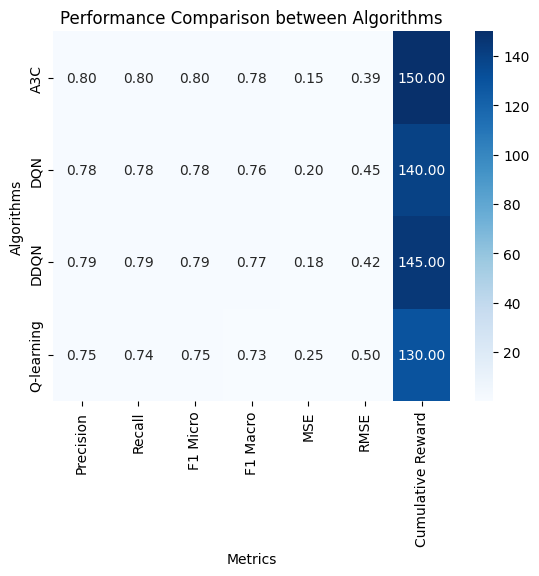

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Sample data for comparison
data = {
    'A3C': [0.8, 0.8, 0.8, 0.78, 0.15, 0.387, 150],
    'DQN': [0.78, 0.78, 0.78, 0.76, 0.2, 0.447, 140],
    'DDQN': [0.79, 0.79, 0.79, 0.77, 0.18, 0.424, 145],
    'Q-learning': [0.75, 0.74, 0.75, 0.73, 0.25, 0.5, 130]
}

# Define the labels for the metrics
metrics = ['Precision', 'Recall', 'F1 Micro', 'F1 Macro', 'MSE', 'RMSE', 'Cumulative Reward']

# Convert data to a numpy array
values = np.array(list(data.values()))

# Create the heatmap
sns.heatmap(values, annot=True, cmap='Blues', xticklabels=metrics, yticklabels=data.keys(), fmt='.2f')

# Set labels and title
plt.xlabel('Metrics')
plt.ylabel('Algorithms')
plt.title('Performance Comparison between Algorithms')

# Show the plot
plt.show()


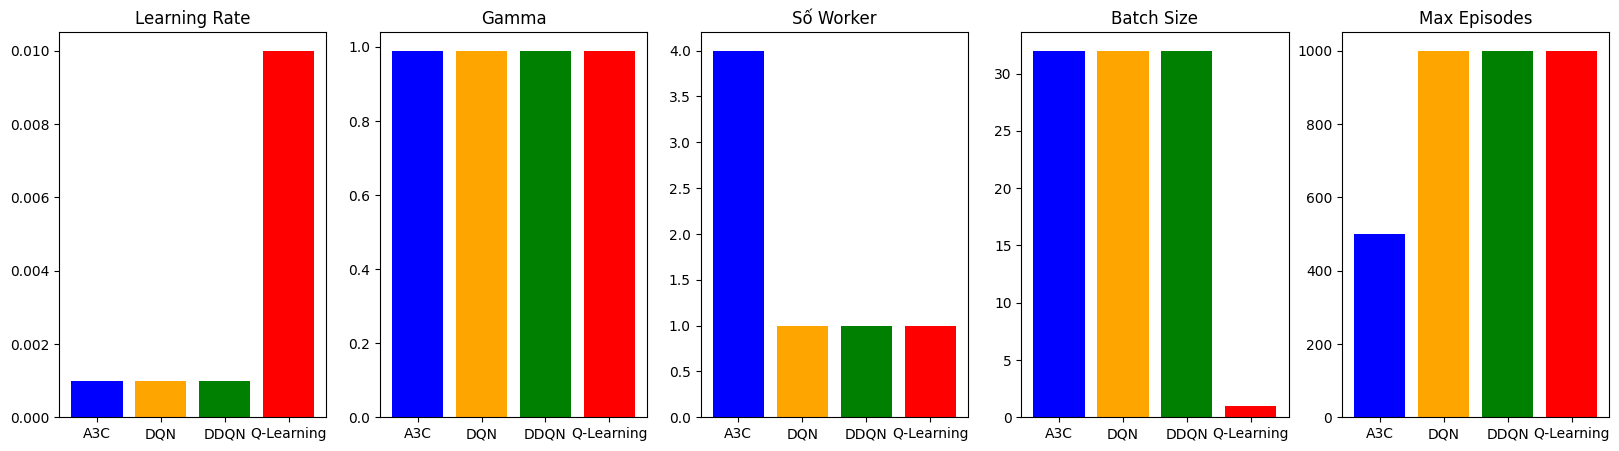

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dữ liệu so sánh các tham số giữa các phương pháp
data = {
    'Learning Rate': [0.001, 0.001, 0.001, 0.01],
    'Gamma': [0.99, 0.99, 0.99, 0.99],
    'Số Worker': [4, 1, 1, 1],
    'Batch Size': [32, 32, 32, 1],
    'Max Episodes': [500, 1000, 1000, 1000],
}

# Tên các phương pháp
methods = ['A3C', 'DQN', 'DDQN', 'Q-Learning']

# Tạo biểu đồ cột cho mỗi tham số
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# Vẽ các biểu đồ cột cho các tham số
for i, (param, values) in enumerate(data.items()):
    axes[i].bar(methods, values, color=['blue', 'orange', 'green', 'red'])
    axes[i].set_title(param)
    axes
